In [7]:
import pandas as pd

# Load the uploaded CSV file
file_path = 'Nat_Gas.csv'
nat_gas_df = pd.read_csv(file_path)

# Display basic info and the first few rows
nat_gas_df.info(), nat_gas_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


(None,
       Dates  Prices
 0  10/31/20    10.1
 1  11/30/20    10.3
 2  12/31/20    11.0
 3   1/31/21    10.9
 4   2/28/21    10.9)

C:\Users\GAURAV MISHRA\AppData\Local\Temp\ipykernel_22532\3376334623.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nat_gas_df['Dates'] = pd.to_datetime(nat_gas_df['Dates'])


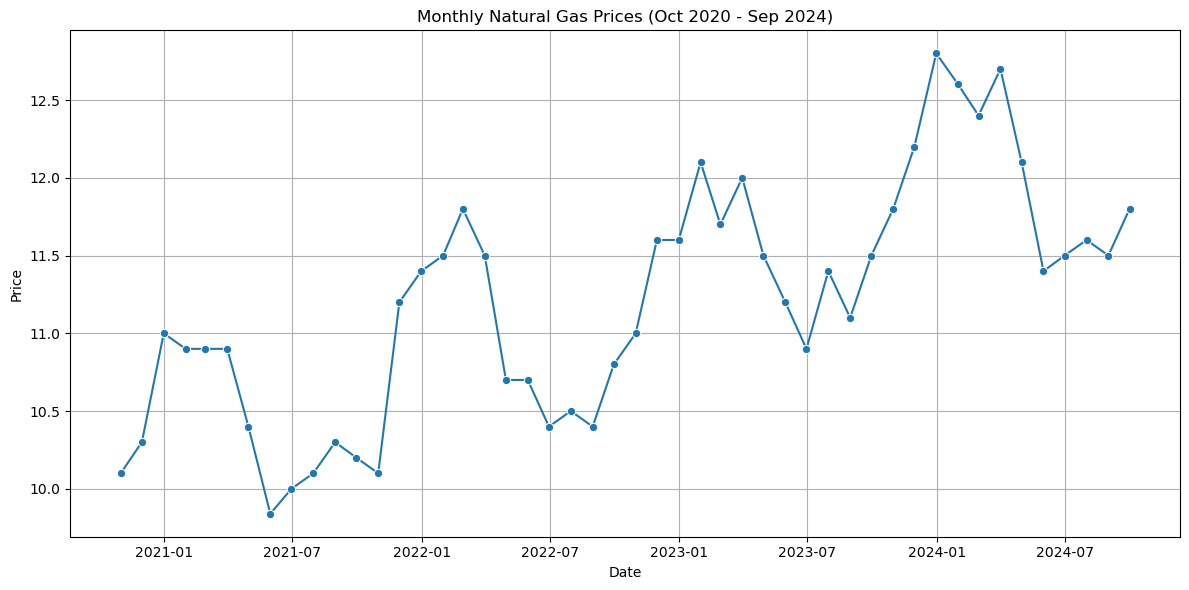

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'Dates' column to datetime
nat_gas_df['Dates'] = pd.to_datetime(nat_gas_df['Dates'])

# Plotting the time series
plt.figure(figsize=(12, 6))
sns.lineplot(data=nat_gas_df, x='Dates', y='Prices', marker='o')
plt.title('Monthly Natural Gas Prices (Oct 2020 - Sep 2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\GAURAV MISHRA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\GAURAV MISHRA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\GAURAV MISHRA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GAURAV MISHRA\AppData\Local\Temp\ipykernel_22532\3767241901.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=ts_data.index[-1] + pd.DateOffset(months=1), periods=12,

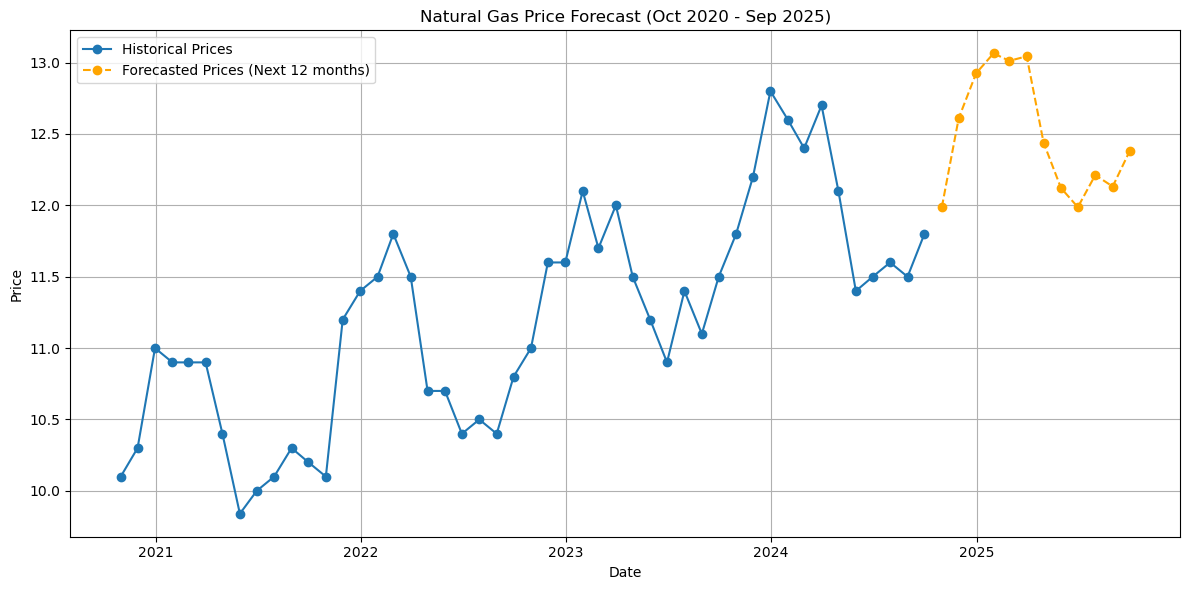

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Set the datetime column as index
ts_data = nat_gas_df.set_index('Dates')['Prices']

# Fit a SARIMA model (seasonal ARIMA for monthly seasonality)
model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

# Forecast for next 12 months
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start=ts_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# Combine historical and forecast data
full_series = pd.concat([ts_data, forecast_series])

# Plot full data with forecast
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Historical Prices', marker='o')
plt.plot(forecast_series, label='Forecasted Prices (Next 12 months)', marker='o', linestyle='--', color='orange')
plt.title('Natural Gas Price Forecast (Oct 2020 - Sep 2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from scipy.interpolate import interp1d

# Combine historical and forecast into a DataFrame
full_df = pd.concat([
    ts_data.rename('Prices'),
    forecast_series.rename('Prices')
]).reset_index().rename(columns={'index': 'Date'})

# Create interpolation function for known dates
interp_func = interp1d(
    x=full_df['Date'].astype(np.int64),
    y=full_df['Prices'],
    kind='linear',
    fill_value='extrapolate'
)

def estimate_gas_price(date_str):
    """
    Estimate the purchase price of natural gas on a given date.
    
    Parameters:
        date_str (str): A date string in 'YYYY-MM-DD' format.
        
    Returns:
        float: Estimated gas price for that date.
    """
    try:
        query_date = pd.to_datetime(date_str)
        timestamp = query_date.to_datetime64().astype(np.int64)
        price_estimate = float(interp_func(timestamp))
        return round(price_estimate, 2)
    except Exception as e:
        return f"Error: {str(e)}"

# Example usage
example_dates = ['2022-06-15', '2024-10-31', '2025-07-31']
{date: estimate_gas_price(date) for date in example_dates}


{'2022-06-15': 10.55, '2024-10-31': 11.99, '2025-07-31': 12.21}

In [16]:
import pandas as pd

# Load the uploaded CSV file to inspect its structure
file_path = "Nat_Gas.csv"
df = pd.read_csv(file_path)

# Show the first few rows of the data
df.head()


,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [56]:
import pandas as pd
from datetime import datetime

# Create the DataFrame with necessary data
# This is the missing part that caused the error
data = {
    'Dates': ['10/31/20', '11/30/20', '12/31/20', '1/31/21'],
    'Prices': [10.1, 10.3, 11, 10.9]  # Example prices
}
df = pd.DataFrame(data)

# Convert Dates column to datetime format
df['Dates'] = pd.to_datetime(df['Dates'])

# Set Dates as index for easy lookup
df.set_index('Dates', inplace=True)

# Pricing model function
def price_storage_contract(
    injection_dates, withdrawal_dates,
    rate_injection, rate_withdrawal,
    max_volume, storage_cost_per_unit
):
    storage = 0
    cash_flows = []

    # Process injection
    for date_str in injection_dates:
        date = pd.to_datetime(date_str)
        if date in df.index:
            injected = min(rate_injection, max_volume - storage)
            cost = -injected * df.loc[date, 'Prices']
            cash_flows.append((date, cost))
            storage += injected

    # Process withdrawal
    for date_str in withdrawal_dates:
        date = pd.to_datetime(date_str)
        if date in df.index:
            withdrawn = min(rate_withdrawal, storage)
            revenue = withdrawn * df.loc[date, 'Prices']
            cash_flows.append((date, revenue))
            storage -= withdrawn

    # Add storage cost (assumed to be monthly)
    date_range = pd.date_range(start=min(injection_dates + withdrawal_dates),
                               end=max(injection_dates + withdrawal_dates), freq='M')
    for date in date_range:
        cost = -storage_cost_per_unit * storage
        cash_flows.append((date, cost))

    # Sum all cash flows
    total_value = sum(cf[1] for cf in cash_flows)

    return total_value, cash_flows

# Example test
test_injection_dates = ['10/31/20', '11/30/20'] # Autumn
test_withdrawal_dates = ['12/31/20', '1/31/21'] # Winter (peak demand)
test_result = price_storage_contract(
    test_injection_dates,
    test_withdrawal_dates,
    rate_injection=100,
    rate_withdrawal=100,
    max_volume=200,
    storage_cost_per_unit=0.1
)

test_result[0]  # Net contract value


C:\Users\GAURAV MISHRA\AppData\Local\Temp\ipykernel_22532\167831069.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])
C:\Users\GAURAV MISHRA\AppData\Local\Temp\ipykernel_22532\167831069.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=min(injection_dates + withdrawal_dates),


150.0